Using this code should be able to run the MCMC sampling algorithm on any set of data.

Input: (p-value, locations)

Output: significant clusters

In [346]:
using Distributions
using PyPlot
data = readdlm("fMRI_2.txt", header = true)
header = data[2];
data = data[1];
header

1x6 Array{AbstractString,2}:
 "voxel"  "x"  "y"  "z"  "ROI"  "pvalue"

In [347]:
ROI = data[:,5];
pvalues = data[:,6];
locations = data[:,2:4];


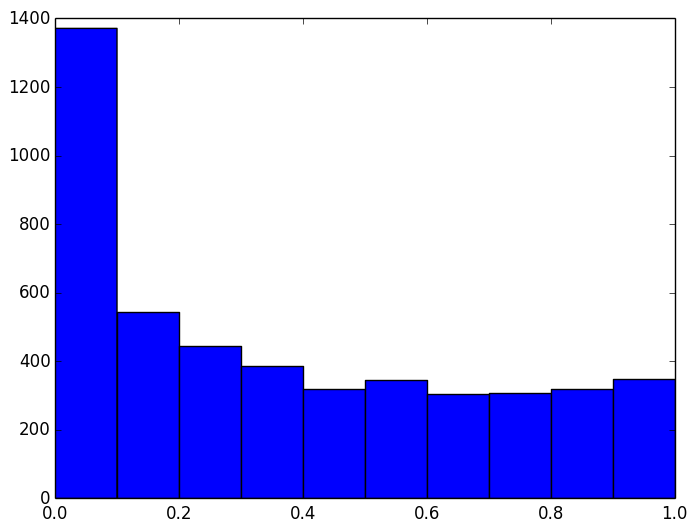

In [348]:
plt[:hist](pvalues);

In [349]:
#returns the sphere in 3d or 2d (represented as an array of points) associated 
#with the given radius and center
#right now only works with 3dimensions will change this when I figure out product iterators
function getSphere(center, radius, locations, dimension)
    if(dimension == 2)
        cluster = Array{Float64,2}[];
        min_x,min_y = Array{Int}(minimum(locations.-center,1));
        max_x,max_y = Array{Int}(maximum(locations.-center,1)); 
        for x in max(-radius,min_x):min(radius,max_x)
            for y in max(-radius,min_y):min(radius,max_y)
                if x*x + y*y <= radius^2
                    push!(cluster, center + [x y])
                end
            end
        end
        return cluster; 
    end
        
    #otherwise dimension = 3
    cluster = Array{Float64,2}[];
    min_x,min_y,min_z = Array{Int}(minimum(locations.-center,1));
    max_x,max_y,max_z = Array{Int}(maximum(locations.-center,1)); 
    for x in max(-radius,min_x):min(radius,max_x)
        for y in max(-radius,min_y):min(radius,max_y)
            for z in max(-radius,min_z):min(radius,max_z)
                if x*x + y*y + z*z <= radius^2
                    push!(cluster, center + [x y z])
                end
            end
        end
    end
    return cluster; 
end

getSphere (generic function with 1 method)

In [350]:
#given proposal returns the step that metropolis chooses
function getMetropolisStep(prop, curr, prior_dist, curr_dist, prop_dist, data)
    n = length(data)
    likelihood_current = loglikelihood(curr_dist, data);
    likelihood_prop = loglikelihood(prop_dist, data); 

    prior_current = log(pdf(prior_dist, curr));
    prior_prop = log(pdf(prior_dist, prop));

    p_curr = likelihood_current+prior_current;
    p_prop = likelihood_prop+prior_prop;

    p_accept = exp(p_prop-p_curr); 

    #flip a p-weighted coin to determine whether we accept the change
    if(rand() < p_accept)
        return prop; 
    end
    return curr; 
end

getMetropolisStep (generic function with 1 method)

In [351]:
function getLabels(pvalues, locations, numiters = 1000)
    if(length(pvalues) != size(locations,1))
        println("Error: input vectors should have same length.")
    end
    n = length(pvalues); 
    dim = size(locations,2); 

    #get pvalue index of corresponding location 
    row_indicies = Dict{Array{Float64,2},Int64}(); 
    n = size(locations,1)
    for i in 1:n
        row_indicies[locations[i,:]] = i;
    end  
    
    ##################################################
    ##### initialize parameters and prior distributions 
    ##################################################
    
    println("Initializing parameters and prior distributions.");
    
    #prior distribution on beta
    mu = 8; 
    sigma = 5; 
    Beta_priordist = TruncatedNormal(mu, sigma, 2, 200);

    #prior distribution on number of signal clusters
    Clusters_priordist = Truncated(Poisson(50), 1, 500)

    #prior distribution on radius of clusters
    radius_prior = TruncatedNormal(2, 2, 1,5); 

    #birth rate 
    lambda = 100; 
    birth_rate = lambda;
    t_0 = 1;  #run chain for 1 time step 
    
    #initial labels/clusters
    num_clusters = 2; #initial number of clusters
    labels = ones(n); 
    center_indicies = Float64[];

    for(i in 1:num_clusters)
        radius = round(rand(radius_prior)); 
        ind = rand(DiscreteUniform(1,n));
        push!(center_indicies, ind); 
        center = locations[ind,:]; 
        newCluster = getSphere(center, radius, locations, dim);
        for(point in newCluster)
            index = get(row_indicies, point, -1)
            if(index ==-1) continue; end;
            labels[index] = i+1; #since label 1 is the null label, label+1
        end
    end

    #add null cluster (corresponding to beta = 1) to the beginning 
    b_arr = [1]; 
    b_arr = [b_arr; rand(Beta_priordist,num_clusters)]; #beta distribution parameters
    b_dist = [Beta(1/b,b) for b in b_arr]; #array of beta distributions


    ##################################################
    ##### Functions to calculate likelihoods 
    ##################################################

    println("Calculating initial likelihoods");
    
    
    #calculate log likelihood of cluster at index idx 
    #given pvalues, their labels and the beta distributions
    function calculateClusterLikelihood(pvalues, b_dist, idx, labels)
        cluster = pvalues[labels .== idx];
        return loglikelihood(b_dist[idx], cluster);
    end
    
    #calculate death rate of component j in the model 
    function calculateDeathRate(num_clusters, pvalues, b_dist, Clusters_priordist, idx, cluster_logLikelihoods, labels, l_y, c_y)  
        updated_likelihoods = copy(cluster_logLikelihoods);
        #calculate likelihood after death 
        #updated values 
        cluster = pvalues[labels.==idx];
        updated_likelihoods[1] = updated_likelihoods[1] + loglikelihood(b_dist[1],cluster);
        updated_likelihoods[idx] = 0; 
        l_dy = sum(updated_likelihoods)
        c_dy = loglikelihood(Clusters_priordist, [num_clusters-1]);
        return log(lambda) + (l_dy - l_y) + (c_dy - log(num_clusters) - c_y);
    end

    #save the log likelihood of each cluster in an array so we don't need
    #to recalculate it always, just need to recalculate whenever 
    #deleting a cluster or adding a new one
    cluster_logLikelihoods = Float64[]; 
    for(idx in 1:(num_clusters+1))
        push!(cluster_logLikelihoods, calculateClusterLikelihood(pvalues, b_dist, idx, labels));
    end
    #calculate current model log likelihood by summing over the cluster likelihoods
    l_y = sum(cluster_logLikelihoods)
    c_y = loglikelihood(Clusters_priordist, [num_clusters]);

    #calculate death rate of each cluster in the model 
    delta_arr = zeros(num_clusters)
    for(idx in 1:num_clusters)
        delta_arr[idx] = calculateDeathRate(num_clusters, pvalues, b_dist, Clusters_priordist, idx+1, cluster_logLikelihoods, labels, l_y, c_y);
    end
    death_rate = sum(exp(delta_arr));
    
    #println(delta_arr)
    
    
    ##################################################
    ##### Birth-death chain to sample labels 
    ##################################################
   
    #run the chain for a certain amount of time before collecting samples
    burn_in = round(numiters/2);
    #change constant 20 to variable
    sample_points = round(linspace(burn_in,numiters,20));
    count = 1; 
    label_arr = zeros(length(pvalues),20); 

    
    #distribution of signal betas
    bcurr_arr = b_arr[2:end];
    
    println("Warming up the chain.");
    for idx_1 in 1:numiters
        curr_time = 0; 
        while(curr_time < t_0)
            #simulate time to next birth/death from an exponential distribution 
            #with mean: birth_rate + death_rate
            t = 1/rand(Exponential(birth_rate + exp(death_rate)));
            curr_time = curr_time + t; 
            
            #flip a weighted coin to determine birth or death 
            is_birth = rand(Bernoulli(birth_rate/(birth_rate + death_rate)));

            if(is_birth == 1)
                #we have a birth 
                #println("Great! The population is growing, it's now size: ", num_clusters+1);

                #only choose cluster centers that are not
                #already centers of an existing current cluster
                ind = rand(DiscreteUniform(1,n));
                while(ind in center_indicies)
                    ind = rand(DiscreteUniform(1,n));
                end
                radius = round(rand(radius_prior)); 
                center = locations[ind,:]; 
                newCluster = getSphere(center, radius, locations, dim);    


                for(point in newCluster)
                    index = get(row_indicies, point, -1)
                    if(index ==-1) continue; end; #if location is not there (a hole in the topology)                   
                    #println(labels[index]);
                    if(labels[index] != 1) continue;end; #only relabel null signals
                    new_label = num_clusters + 2; 
                    labels[index] = new_label; 
                end

                #simulate the beta parameter associated with 
                #this cluster from the prior
                b = rand(Beta_priordist)
                #update parameter vectors
                push!(bcurr_arr, b)
                push!(center_indicies, ind); 
                num_clusters = num_clusters + 1; 
                b_dist = [Beta(1/b,b) for b in [1; bcurr_arr]];
                #update model likelihoods 
                #Note that the null cluster 
                #log likelihood is always 0 when it's uniform so we don't bother updating it

                #add likelihood of new cluster 
                push!(cluster_logLikelihoods, calculateClusterLikelihood(pvalues, b_dist, num_clusters+1, labels))

                #calculate current model log likelihood by summing over the cluster likelihoods
                l_y = sum(cluster_logLikelihoods)
                c_y = loglikelihood(Clusters_priordist, [num_clusters]);

                #calculate death rate of additional component
                push!(delta_arr, calculateDeathRate(num_clusters, pvalues, b_dist, Clusters_priordist, num_clusters+1, cluster_logLikelihoods, labels, l_y, c_y));
                death_rate = sum(exp(delta_arr));

            else
                #we have a death 

                #select a component to die by sampling from a 
                #categorical distribution with vector delta_arr/death_rate
                sure_deaths = find(delta_arr .> 50);
                if(length(sure_deaths) > 0) #for computational issue
                    death_j = sure_deaths[1];
                else
                    sure_deaths = find(delta_arr .== -Inf);
                    if(length(sure_deaths) > 0) #for computational issue
                        death_j = sure_deaths[1];
                    else
                        death_j = rand(Categorical(vec(exp(delta_arr)./death_rate)));
                    end
                end
                #println("Oh no! A cluster with death rate ", (delta_arr./death_rate)[death_j], " has perished.");
                
                #update parameter vectors
                deleteat!(bcurr_arr, death_j);
                deleteat!(center_indicies, death_j);
                labels[labels.== death_j+1] = 1; 
                for(z in (death_j+2):(num_clusters+1))
                    labels[labels.==z] = z-1; 
                end
                num_clusters = num_clusters - 1; 

                #update model likelihoods
                deleteat!(cluster_logLikelihoods, death_j+1); #remove the cluster that's gone

                #calculate current model log likelihood by summing over the cluster likelihoods
                l_y = sum(cluster_logLikelihoods)
                c_y = loglikelihood(Clusters_priordist, [num_clusters]);

                #update death rate 
                deleteat!(delta_arr, death_j);
                death_rate = sum(exp(delta_arr));                
            end
            #println(delta_arr)
            #repeat until curr_time = t_0
        end
        if(idx_1 == burn_in)
            println("Starting to collect samples...")
        end
        
        #sample labels from evenly space grid along the chain
        if(idx_1 in sample_points)
            println(count)
            label_arr[:,count] = labels; 
            count = count+1; 
        end
        
        ###run metropolis to sample from the posterior of the beta distribution 
        for(curr_label in 1:num_clusters) 
            avg = 0; 
            num_samples = 10; 
            curr_val = bcurr_arr[curr_label]; 
            for(i in 1:num_samples)
                prop_width = 0.1
                #proposed betas are random step away from each beta
                b_prop = rand(Normal(curr_val, prop_width));
                while(b_prop < 1)  b_prop = rand(Normal(curr_val, prop_width)); end;
                curr_dist = Beta(1/curr_val, curr_val); 
                prop_dist = Beta(1/b_prop, b_prop); 
                cluster = data[find(labels .== curr_label)];
                curr_val = getMetropolisStep(b_prop, curr_val,Beta_priordist,curr_dist, prop_dist,cluster);
                avg = avg + curr_val; 
            end
            bcurr_arr[curr_label] = avg/num_samples;
        end
        b_arr = vec([1; bcurr_arr]);
        #continue running chain
    end
   
    return label_arr, b_arr
end


getLabels (generic function with 2 methods)

In [352]:
tic();
#@profile getLabels(pvalues, locations); 
label_arr, b_arr = getLabels(pvalues, locations,10000); 
toc(); 

Initializing parameters and prior distributions.
Calculating initial likelihoods
Warming up the chain.
Starting to collect samples...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
elapsed time: 461.238193223 seconds


In [353]:
label_arr[label_arr.!=1] = -1;
labels = sum(label_arr,2); 
labels[labels.>0] = 1;
labels[labels.<0] = 0; 

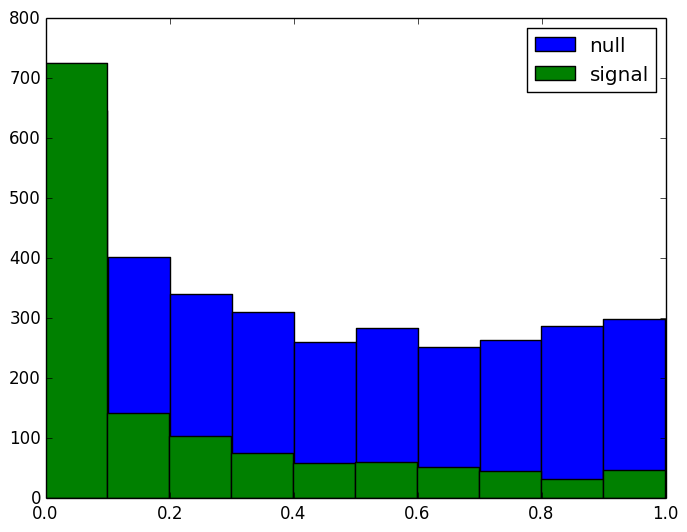

In [362]:
plt[:hist](pvalues[find(labels.==1)], label = "null") #data associated with null cluster
plt[:hist](pvalues[find(labels.!=1)], label = "signal") #data associated with signals 
legend();

In [337]:
#check if this works for 2d
#n by n grid with a set number of clusters
n = 100; 
k = 3; 
dim =2; 

#prior distribution on beta
mu = 3; 
sigma = 5; 
Beta_priordist = TruncatedNormal(mu, sigma, 2, 200);

#prior distribution on number of signal clusters
Clusters_priordist = Truncated(Poisson(50), 2, 500)

#prior distribution on radius of clusters
radius_prior = TruncatedNormal(4, 2, 1,10); 

#p-values which are null are generated 
#from a uniform distribution 
null_dist = Uniform(0,1);
locations = [0 0];
for(i in 1:n)
    for(j in 1:n)
        locations = vcat(locations, [i j]);
    end
end
locations = locations[2:end,:];

#generate map from location to pvalue
row_indicies = Dict{Array{Float64,2},Int64}(); 
for i in 1:size(locations,1)
    row_indicies[locations[i,:]] = i;
end

#all pvalues other than clusters
#are drawn from random uniform
pvalues = rand(null_dist,(n*n));
labels = ones(n*n);

#generate k clusters
for(i in 1:k)
    center = [rand(DiscreteUniform(1,n)) rand(DiscreteUniform(1,n))];
    radius = round(rand(radius_prior)); 
    newCluster = getSphere(center, radius, locations, dim);
    beta = rand(Beta_priordist);
    beta_dist = Beta(1/beta,beta);
    for(point in newCluster)
        index = get(row_indicies, point, -1)
        if(index ==-1) continue; end;
        labels[index] = i+1; #since label 1 i
        pvalues[index] = rand(beta_dist);
    end
end

#pcolormesh(reshape(pvalues,n,n))
#colorbar()



In [338]:
tic(); label_arr, b_arr = getLabels(pvalues, locations, 500);toc();

Initializing parameters and prior distributions.
Calculating initial likelihoods
Warming up the chain.
Starting to collect samples...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
elapsed time: 8.389527937 seconds


In [339]:
label_arr[label_arr.!=1] = -1;
labels = sum(label_arr,2); 
labels[labels.>0] = 1;
labels[labels.<0] = 0; 

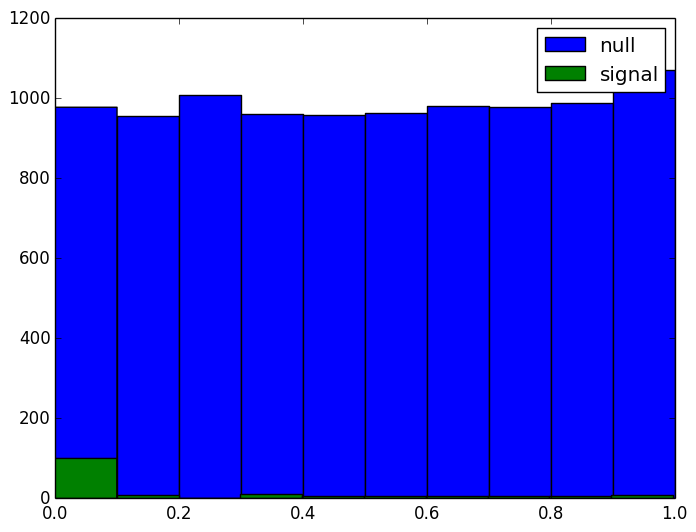

In [340]:
plt[:hist](pvalues[find(labels.==1)], label = "null") #data associated with null cluster
plt[:hist](pvalues[find(labels.!=1)], label = "signal") #data associated with signals 
legend();

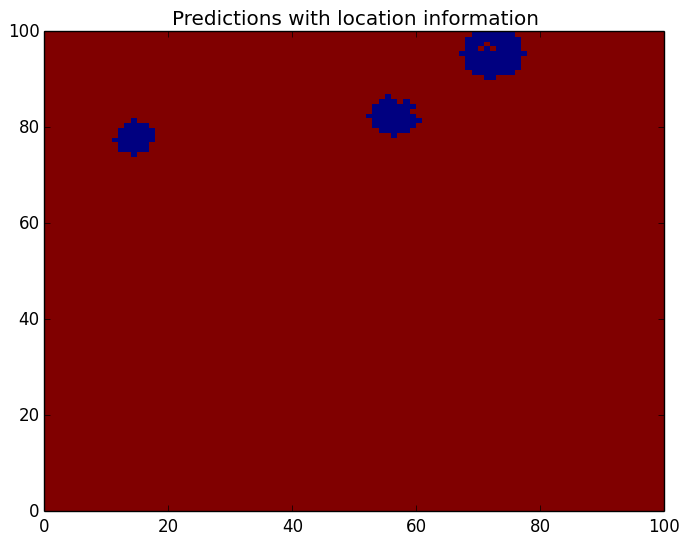

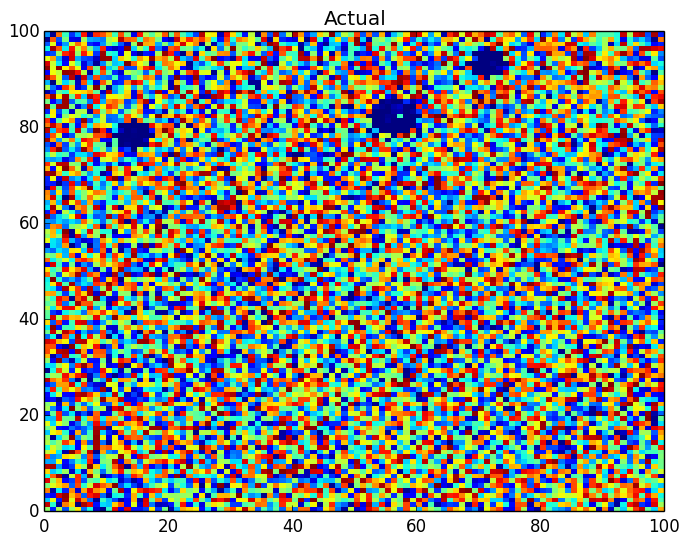

In [341]:
ddd = copy(pvalues);
labels = vec(labels);
ddd[labels.==1] = 1; 
ddd[labels.!=1] = 0; 
dddd = reshape(ddd,n,n);
figure();
title("Predictions with location information");
pcolormesh(dddd);
figure();
title("Actual")
pcolormesh(reshape(pvalues,n,n));